<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import pandas as pd

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
dataset['train']['text'][10]

'It was great to see some of my favorite stars of 30 years ago including John Ritter, Ben Gazarra and Audrey Hepburn. They looked quite wonderful. But that was it. They were not given any characters or good lines to work with. I neither understood or cared what the characters were doing.<br /><br />Some of the smaller female roles were fine, Patty Henson and Colleen Camp were quite competent and confident in their small sidekick parts. They showed some talent and it is sad they didn\'t go on to star in more and better films. Sadly, I didn\'t think Dorothy Stratten got a chance to act in this her only important film role.<br /><br />The film appears to have some fans, and I was very open-minded when I started watching it. I am a big Peter Bogdanovich fan and I enjoyed his last movie, "Cat\'s Meow" and all his early ones from "Targets" to "Nickleodeon". So, it really surprised me that I was barely able to keep awake watching this one.<br /><br />It is ironic that this movie is about a de

In [ ]:
# Получить отдельные предложения и поместить их в sentences

sentences = []
word_threshold = 32

for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='english') if len(word_tokenize(x)) < word_threshold]
        )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 198756


Посчитаем для каждого слова его встречаемость.

In [ ]:
sentences[10]

"nowhere, because they don't exist."

In [ ]:
# Расчет встречаемости слов
words = Counter()
for sentence in  tqdm(sentences):
    words.update(word_tokenize(sentence))

  0%|          | 0/198756 [00:00<?, ?it/s]

In [ ]:
len(words)

69757

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
words.most_common(10)

[('.', 170550),
 ('the', 151411),
 (',', 114297),
 ('a', 75305),
 ('and', 73199),
 ('of', 62882),
 ('to', 60567),
 ('is', 57507),
 ('it', 51871),
 ('i', 48983)]

In [ ]:
# Наполнение словаря
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000
for word, cnt in words.most_common(vocab_size):
    vocab.add(word)

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        # Допишите код здесь
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(char, self.unk_id) for char in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2, random_state = 42)

eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5, random_state = 42)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, shuffle=True, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, shuffle=False, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, shuffle=False, batch_size=batch_size)

In [ ]:
a = next(iter(train_dataloader))
s = a['input_ids'][0].tolist()
print([ind2word[i] for i in s])

['<bos>', 'whether', 'or', 'not', 'the', 'viewer', 'finds', 'the', 'finished', 'product', 'rewarding', 'has', 'much', 'to', 'do', 'with', 'our', 'individual', 'methods', 'of', 'processing', 'visual', 'and', 'conceptual', 'information', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [ ]:
# Напишите код здесь

def train_model(optimizer, criterion, model, num_epoch):
    losses = []
    perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch+1}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, test_dataloader))

    return losses, perplexities

In [ ]:
# Функция для отрисовки графиков
def plot_graph():
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(losses)), losses)
    plt.title('Losses')
    plt.xlabel("epoch")

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(perplexities)), perplexities)
    plt.title('Perplexity')
    plt.xlabel("epoch")

    plt.show()

In [ ]:
# функция генерации
def generate_sequence(model, starting_seq:str, max_seq_len:int=128):
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
      word2ind.get(char.lower(), word2ind['<unk>']) for char in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

### Первый эксперимент (2 балла)

Базовая модель.


Определите архитектуру модели и обучите её.

In [ ]:
# Опишите свою нейронную сеть здесь

class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
# Обучите модель здесь
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
model

LanguageModel(
  (embedding): Embedding(40004, 256)
  (rnn): GRU(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=40004, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
losses, perplexities = train_model(optimizer, criterion, model, 5)

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

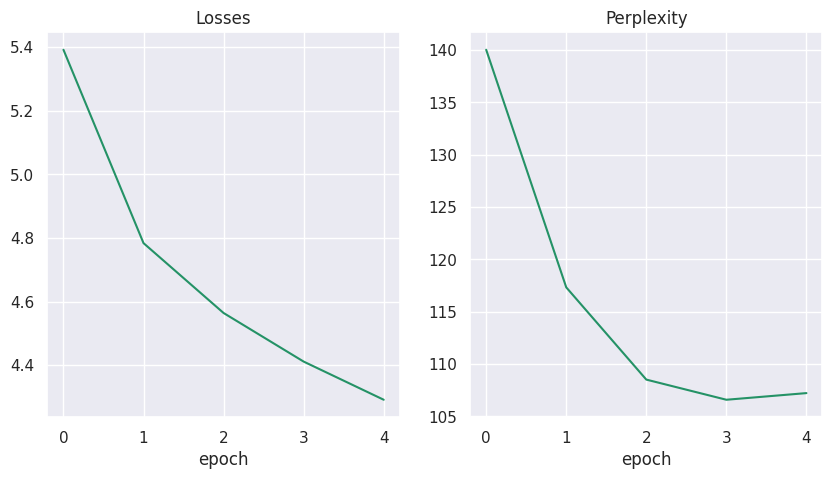

Лучшая perplexities: 140.04


In [ ]:
plot_graph()
print(f"Лучшая perplexities: {(min(perplexities)):.2f}")

In [ ]:
generate_sequence(model, starting_seq='I have many favourite artists')

'<bos> i have many favourite artists who have seen this movie . <eos>'

In [ ]:
# сохранение результата в таблицу
import pandas as pd
compare_df1 = pd.DataFrame({'perplexities': round(min(perplexities), 3),
                            'type_RNN/num_layers': ['GRU ; num_layers = 1 '],
                            'hidden_dim/num_of_nn.Linear/activation': ['256, 2; nn.Tanh'],
                            'normalization': ['nn.Dropout(p=0.1)'],
                            'optimizer/lr': ['Adam; 0.001']}, index = ['experiment_1'])
compare_df1

,perplexities,type_RNN/num_layers,hidden_dim/num_of_nn.Linear/activation,normalization,optimizer/lr
experiment_1,106.597,GRU ; num_layers = 1,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001


### Второй эксперимент (2 балла)




#### Эксперимент 2.1


```
LSTM модель / num_layers = 2
```

In [ ]:
# Проведите второй эксперимент
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers = 2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim,num_layers = 2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
# Обучите модель здесь
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
losses, perplexities = train_model(optimizer, criterion, model, 5)

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

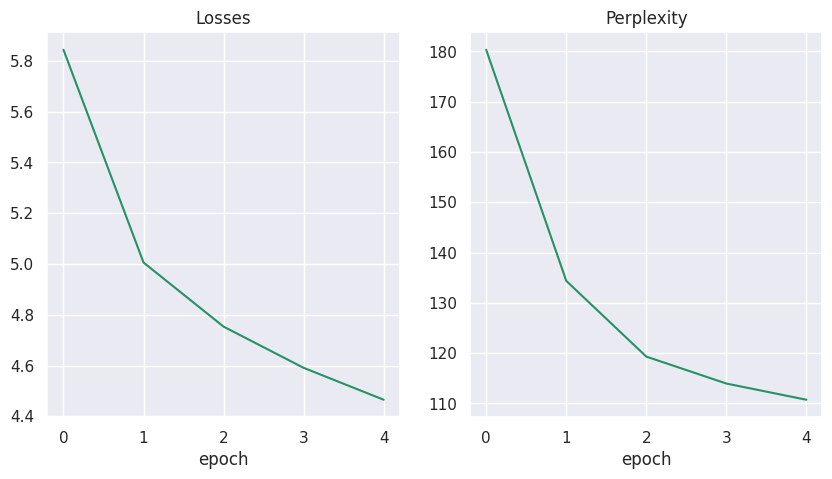

Лучшая perplexities: 110.73


In [ ]:
plot_graph()
print(f"Лучшая perplexities: {(min(perplexities)):.2f}")

In [ ]:
generate_sequence(model, starting_seq='I have many favourite artists')

"<bos> i have many favourite artists of the movie , but i was n't sure about this movie . <eos>"

In [ ]:
# сохранение результата в таблицу
import pandas as pd
compare_df2 = pd.DataFrame({'perplexities': round(min(perplexities), 3),
                            'type_RNN/num_layers': ['LSTM; num_layers = 2'],
                            'hidden_dim/num_of_nn.Linear/activation': ['256, 2; nn.Tanh'],
                            'normalization': ['nn.Dropout(p=0.1)'],
                            'optimizer/lr': ['Adam; 0.001']}, index = ['experiment_2'])
compare_df2

,perplexities,type_RNN/num_layers,hidden_dim/num_of_nn.Linear/activation,normalization,optimizer/lr
experiment_2,110.732,LSTM; num_layers = 2,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001


In [ ]:
compare_df3 =  pd.concat((compare_df1, compare_df2), axis = 0)
compare_df = compare_df3
compare_df.to_pickle("compare_result.df", compression="gzip")
compare_df

,perplexities,type_RNN/num_layers,hidden_dim/num_of_nn.Linear/activation,normalization,optimizer/lr
experiment_1,106.597,GRU ; num_layers = 1,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001
experiment_2,110.732,LSTM; num_layers = 2,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001


In [ ]:
generate_sequence(model, starting_seq='I have many favourite artists')

"<bos> i have many favourite artists of the movie , but i was n't sure about this movie . <eos>"

#### Эксперимент 2.2


```
LSTM модель / num_layers = 2 / ReLU / Dropout 0.3
```


In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers = 2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim,num_layers = 2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
# Обучите модель здесь
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
losses, perplexities = train_model(optimizer, criterion, model, 10)

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/1243 [00:00<?, ?it/s]

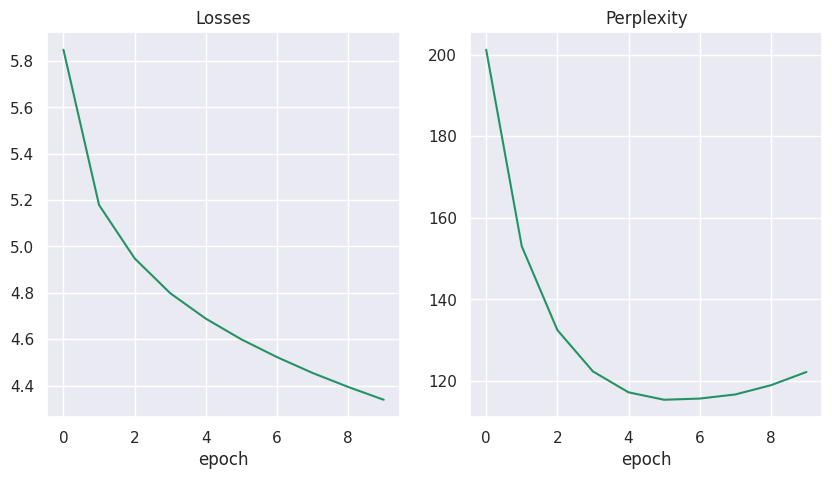

Лучшая perplexities: 115.41


In [ ]:
plot_graph()
print(f"Лучшая perplexities: {(min(perplexities)):.2f}")

In [ ]:
generate_sequence(model, starting_seq='I have many favourite artists')

"<bos> i have many favourite artists in the movie , but i was n't expecting much . <eos>"

In [ ]:
# сохранение результата в таблицу
import pandas as pd
compare_df4 = pd.DataFrame({'perplexities': round(min(perplexities), 3),
                            'type_RNN/num_layers': ['LSTM; num_layers = 2'],
                            'hidden_dim/num_of_nn.Linear/activation': ['256, 2; nn.ReLU'],
                            'normalization': ['nn.Dropout(p=0.3)'],
                            'optimizer/lr': ['Adam; 0.001']}, index = ['experiment_3'])
compare_df4

,perplexities,type_RNN/num_layers,hidden_dim/num_of_nn.Linear/activation,normalization,optimizer/lr
experiment_3,115.413,LSTM; num_layers = 2,"256, 2; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.001


In [ ]:
compare_df5 =  pd.concat((compare_df3, compare_df4), axis = 0)
compare_df = compare_df5
compare_df.to_pickle("compare_result.df", compression="gzip")
compare_df

,perplexities,type_RNN/num_layers,hidden_dim/num_of_nn.Linear/activation,normalization,optimizer/lr
experiment_1,106.597,GRU ; num_layers = 1,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001
experiment_2,110.732,LSTM; num_layers = 2,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001
experiment_3,115.413,LSTM; num_layers = 2,"256, 2; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.001


#### Эксперимент 2.3



```
LSTM модель / num_layers = 2 / ReLU / Dropout 0.3 / hidden_dim = 512
```



In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers = 2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)


    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear1(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear2(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
# Обучите модель здесь
model = LanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
model

LanguageModel(
  (embedding): Embedding(40004, 512)
  (rnn): LSTM(512, 512, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (projection): Linear(in_features=512, out_features=40004, bias=True)
  (non_lin): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
losses, perplexities = train_model(optimizer, criterion, model, 5)

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

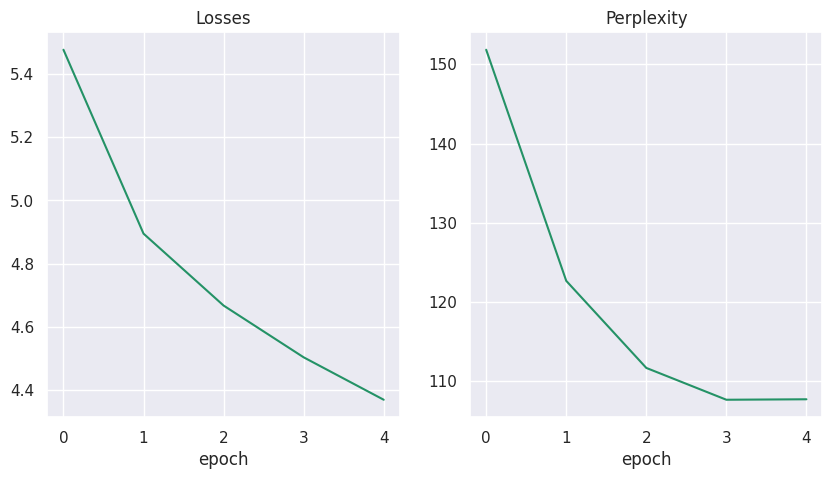

Лучшая perplexities: 107.67


In [ ]:
plot_graph()
print(f"Лучшая perplexities: {(min(perplexities)):.2f}")

In [ ]:
generate_sequence(model, starting_seq='I have many favourite artists')

"<bos> i have many favourite artists of the movie , but i was n't disappointed . <eos>"

In [ ]:
# сохранение результата в таблицу
import pandas as pd
compare_df6 = pd.DataFrame({'perplexities': round(min(perplexities), 3),
                            'type_RNN/num_layers': ['LSTM; num_layers = 2'],
                            'hidden_dim/num_of_nn.Linear/activation': ['512, 3; nn.ReLU'],
                            'normalization': ['nn.Dropout(p=0.3)'],
                            'optimizer/lr': ['Adam; 0.001']}, index = ['experiment_4'])
compare_df6

,perplexities,type_RNN/num_layers,hidden_dim/num_of_nn.Linear/activation,normalization,optimizer/lr
experiment_4,107.672,LSTM; num_layers = 2,"512, 3; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.001


In [ ]:
compare_df7 =  pd.concat((compare_df5, compare_df6), axis = 0)
compare_df = compare_df7
compare_df.to_pickle("compare_result.df", compression="gzip")
compare_df

,perplexities,type_RNN/num_layers,hidden_dim/num_of_nn.Linear/activation,normalization,optimizer/lr
experiment_1,106.597,GRU ; num_layers = 1,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001
experiment_2,110.732,LSTM; num_layers = 2,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001
experiment_3,115.413,LSTM; num_layers = 2,"256, 2; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.001
experiment_4,107.672,LSTM; num_layers = 2,"512, 3; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.001


#### Эксперимент 2.4


```
LSTM модель / num_layers = 2 / ReLU / Dropout 0.3 / hidden_dim = 512 / RMSprop
```

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers = 2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)


    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear1(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear2(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
# Обучите модель здесь
model = LanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [ ]:
losses, perplexities = train_model(optimizer, criterion, model, 5)

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

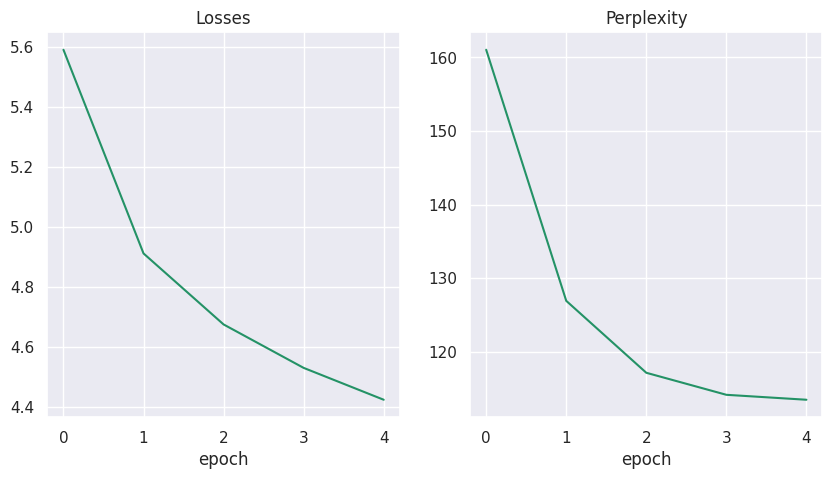

Лучшая perplexities: 113.44


In [ ]:
plot_graph()
print(f"Лучшая perplexities: {(min(perplexities)):.2f}")

In [ ]:
generate_sequence(model, starting_seq='I have many favourite artists')

'<bos> i have many favourite artists and i was not disappointed . <eos>'

In [ ]:
# сохранение результата в таблицу
compare_df8 = pd.DataFrame({'perplexities': round(min(perplexities), 3),
                            'type_RNN/num_layers': ['LSTM; num_layers = 2'],
                            'hidden_dim/num_of_nn.Linear/activation': ['512, 3; nn.ReLU'],
                            'normalization': ['nn.Dropout(p=0.3)'],
                            'optimizer/lr': ['RMSprop; 0.001']}, index = ['experiment_5'])
# compare_df8

compare_df9 =  pd.concat((compare_df7, compare_df8), axis = 0)
compare_df = compare_df9
compare_df.to_pickle("compare_result.df", compression="gzip")
compare_df

,perplexities,type_RNN/num_layers,hidden_dim/num_of_nn.Linear/activation,normalization,optimizer/lr
experiment_1,106.597,GRU ; num_layers = 1,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001
experiment_2,110.732,LSTM; num_layers = 2,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001
experiment_3,115.413,LSTM; num_layers = 2,"256, 2; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.001
experiment_4,107.672,LSTM; num_layers = 2,"512, 3; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.001
experiment_5,113.441,LSTM; num_layers = 2,"512, 3; nn.ReLU",nn.Dropout(p=0.3),RMSprop; 0.001


In [ ]:
# Обучите модель здесь
model = LanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
losses, perplexities = train_model(optimizer, criterion, model, 5)

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

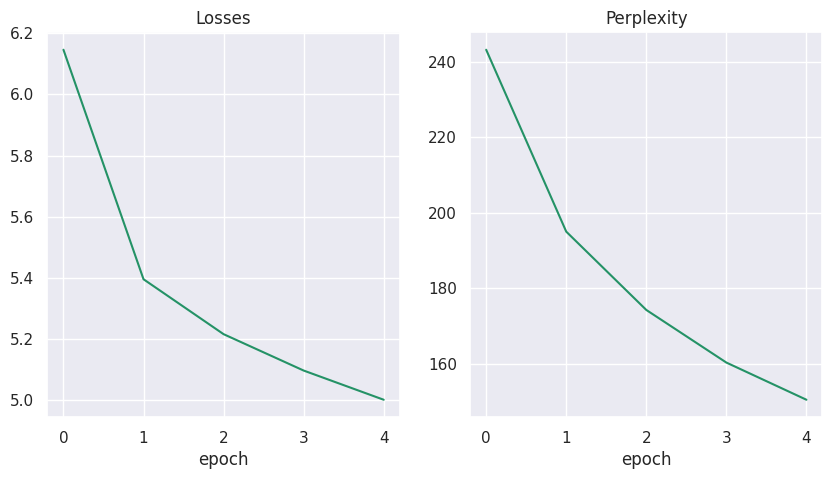

Лучшая perplexities: 150.44


In [ ]:
plot_graph()
print(f"Лучшая perplexities: {(min(perplexities)):.2f}")

#### Эксперимент 2.5



```
Обучение с подбором learning_rate с применением lr_scheduler StepLR
LSTM модель / num_layers = 2 / ReLU / Dropout 0.3 / hidden_dim = 512 / Adam /StepLR
```



In [ ]:
# функция с lr_scheduler
def train_model(optimizer, criterion, scheduler, model, num_epoch):
    losses = []
    perplexities = []
    schedul = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch+1}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, test_dataloader))
        scheduler.step()
        schedul.append(optimizer.state_dict()['param_groups'][0]['lr'])

    return losses, perplexities, schedul

In [ ]:
model = LanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

losses, perplexities, scheduler = train_model(optimizer, criterion, scheduler, model, 6)

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1243 [00:00<?, ?it/s]

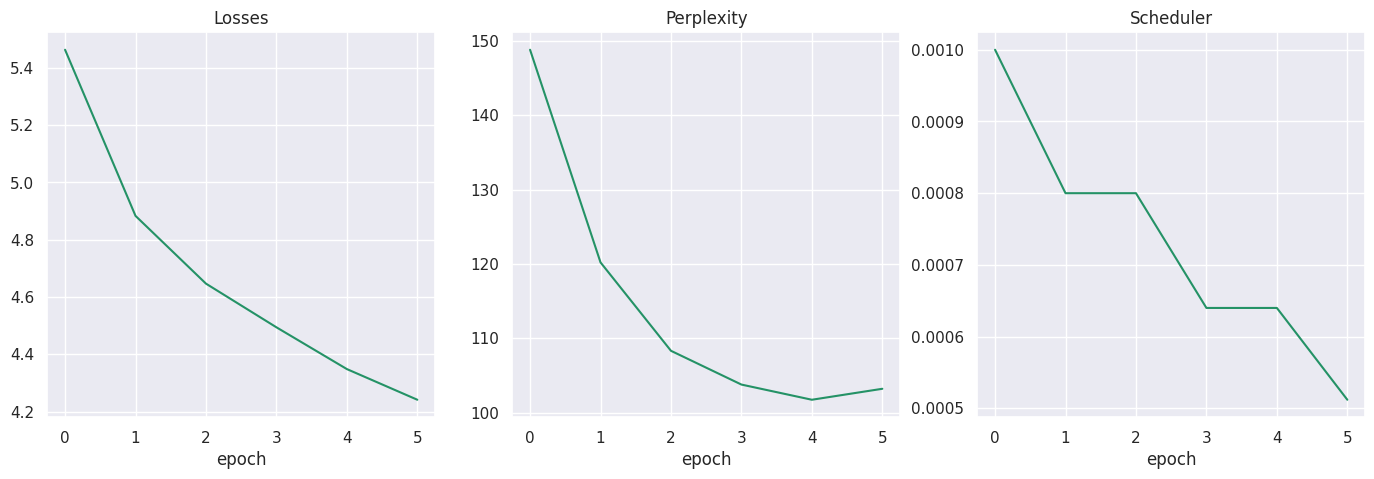

Лучшая perplexities: 101.74


In [ ]:
# Функция для отрисовки графиков

plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

plt.subplot(1, 3, 2)
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")

plt.subplot(1, 3, 3)
plt.plot(np.arange(len(scheduler)), scheduler)
plt.title('Scheduler')
plt.xlabel("epoch")

plt.show()

print(f"Лучшая perplexities: {(min(perplexities)):.2f}")

In [ ]:
# сохранение результата в таблицу
compare_df8 = pd.DataFrame({'perplexities': round(min(perplexities), 3),
                            'type_RNN/num_layers': ['LSTM; num_layers = 2'],
                            'hidden_dim/num_of_nn.Linear/activation': ['512, 3; nn.ReLU'],
                            'normalization': ['nn.Dropout(p=0.3)'],
                            'optimizer/lr': ['Adam; StepLR(0.00052)']}, index = ['experiment_6'])
# compare_df8

compare_df9 =  pd.concat((compare_df, compare_df8), axis = 0)
compare_df = compare_df9
compare_df.to_pickle("compare_result.df", compression="gzip")
compare_df

,perplexities,type_RNN/num_layers,hidden_dim/num_of_nn.Linear/activation,normalization,optimizer/lr
experiment_1,106.597,GRU ; num_layers = 1,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001
experiment_2,110.732,LSTM; num_layers = 2,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001
experiment_3,115.413,LSTM; num_layers = 2,"256, 2; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.001
experiment_4,107.672,LSTM; num_layers = 2,"512, 3; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.001
experiment_5,113.441,LSTM; num_layers = 2,"512, 3; nn.ReLU",nn.Dropout(p=0.3),RMSprop; 0.001
experiment_6,101.738,LSTM; num_layers = 2,"512, 3; nn.ReLU",nn.Dropout(p=0.3),Adam; StepLR(0.00052)


### Третий эксперимент

#### Эксперимент 3.1



```
Увеличение размера датасета для обучения - возьмем и соединим все части датасета (в итоге будем иметь датасет на 100000 записей)

обучение с подобранными ранее параметрами:
LSTM модель / num_layers = 2 / ReLU / Dropout 0.3 / hidden_dim = 512 / Adam /lr=0.00052

```



In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
data = dataset['train']['text'] + dataset['test']['text'] + dataset['unsupervised']['text']
len(data)

100000

In [ ]:
# Получить отдельные предложения и поместить их в sentences

sentences = []
word_threshold = 32

for sentence in tqdm(data):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='english') if len(word_tokenize(x)) < word_threshold]
        )

print("Всего предложений:", len(sentences))

  0%|          | 0/100000 [00:00<?, ?it/s]

Всего предложений: 786666


In [ ]:
# Расчет встречаемости слов
words = Counter()
for sentence in  tqdm(sentences):
    words.update(word_tokenize(sentence))

  0%|          | 0/786666 [00:00<?, ?it/s]

In [ ]:
# Наполнение словаря

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000
for word, cnt in words.most_common(vocab_size):
    vocab.add(word)

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        # Допишите код здесь
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(char, self.unk_id) for char in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2, random_state = 42)

eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5, random_state = 42)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, shuffle=True, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, shuffle=False, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, shuffle=False, batch_size=batch_size)

In [ ]:
a = next(iter(train_dataloader))
s = a['input_ids'][0].tolist()
print([ind2word[i] for i in s])

['<bos>', 'i', 'think', 'if', 'you', 'realize', 'its', 'rated', 'r', 'then', 'you', 'will', 'be', 'prepared', 'for', 'the', 'nudity', 'and', 'drug', 'use', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
# Обучите модель здесь
model = LanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.00052)

losses, perplexities = train_model(optimizer, criterion, model, 5)

Training epoch 1::   0%|          | 0/4917 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4917 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4917 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4917 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4917 [00:00<?, ?it/s]

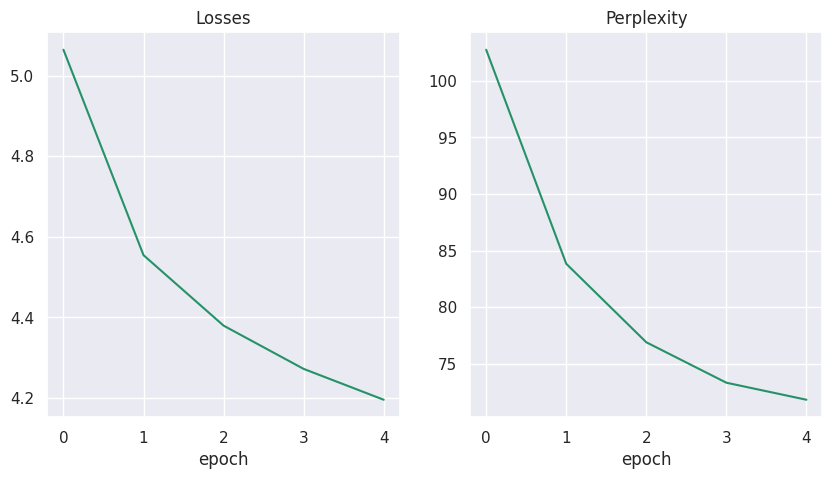

Лучшая perplexities: 71.81


In [ ]:
plot_graph()
print(f"Лучшая perplexities: {(min(perplexities)):.2f}")

In [ ]:
generate_sequence(model, starting_seq='I have many favourite artists')

'<bos> i have many favourite artists of the world . <eos>'

In [ ]:
# сохранение результата в таблицу
compare_df10 = pd.DataFrame({'perplexities': round(min(perplexities), 3),
                            'type_RNN/num_layers': ['LSTM; num_layers = 2; df = 1000000'],
                            'hidden_dim/num_of_nn.Linear/activation': ['512, 3; nn.ReLU'],
                            'normalization': ['nn.Dropout(p=0.3)'],
                            'optimizer/lr': ['Adam; 0.00052']}, index = ['experiment_7'])

compare_df11 =  pd.concat((compare_df, compare_df10), axis = 0)
compare_df = compare_df11
compare_df.to_pickle("compare_result.df", compression="gzip")
compare_df

,perplexities,type_RNN/num_layers,hidden_dim/num_of_nn.Linear/activation,normalization,optimizer/lr
experiment_1,106.597,GRU ; num_layers = 1,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001
experiment_2,110.732,LSTM; num_layers = 2,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001
experiment_3,115.413,LSTM; num_layers = 2,"256, 2; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.001
experiment_4,107.672,LSTM; num_layers = 2,"512, 3; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.001
experiment_5,113.441,LSTM; num_layers = 2,"512, 3; nn.ReLU",nn.Dropout(p=0.3),RMSprop; 0.001
experiment_6,101.738,LSTM; num_layers = 2,"512, 3; nn.ReLU",nn.Dropout(p=0.3),Adam; StepLR(0.00052)
experiment_7,71.810,LSTM; num_layers = 2; df = 1000000,"512, 3; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.00052


#### Эксперимент 3.2

```
Увеличение размера датасета для обучения - возьмем и соединим все части датасета (в итоге будем иметь датасет на 100000 записей)

+++ добавление BatchNormalization

обучение с подобранными ранее параметрами:
LSTM модель / num_layers = 2 / ReLU / Dropout 0.3 / hidden_dim = 512 / Adam /lr=0.00052

```


добавление BatchNormalization

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers = 2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)


    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.bn(self.linear1(self.non_lin(output)).permute(0, 2, 1))
        output = self.dropout(self.linear2(self.non_lin(output.permute(0, 2, 1))))
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
model = LanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)
model

LanguageModel(
  (embedding): Embedding(40004, 512)
  (rnn): LSTM(512, 512, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (projection): Linear(in_features=512, out_features=40004, bias=True)
  (non_lin): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
# Обучите модель здесь
# model = LanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.00052)

losses, perplexities = train_model(optimizer, criterion, model, 5)

Training epoch 1::   0%|          | 0/4917 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4917 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4917 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4917 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4917 [00:00<?, ?it/s]

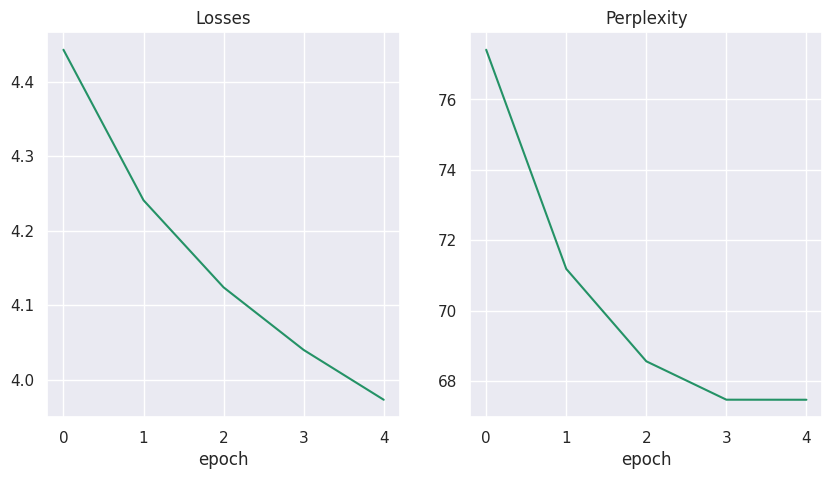

Лучшая perplexities: 67.47


In [ ]:
plot_graph()
print(f"Лучшая perplexities: {(min(perplexities)):.2f}")
# generate_sequence(model, starting_seq='I have many favourite artists')

In [5]:
compare_df10 = pd.DataFrame({'perplexities': round(min(perplexities), 3),
                            'type_RNN/num_layers': ['LSTM; num_layers = 2; df = 1000000'],
                            'hidden_dim/num_of_nn.Linear/activation': ['512, 3; nn.ReLU'],
                            'normalization': ['nn.Dropout(p=0.3)/BatchNormalization'],
                            'optimizer/lr': ['Adam; 0.00052']}, index = ['experiment_8'])
compare_df11 =  pd.concat((compare_df, compare_df10), axis = 0)
compare_df = compare_df11
compare_df.to_pickle("compare_result.df", compression="gzip")
compare_df

,perplexities,type_RNN/num_layers,hidden_dim/num_of_nn.Linear/activation,normalization,optimizer/lr
experiment_1,106.597,GRU ; num_layers = 1,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001
experiment_2,110.732,LSTM; num_layers = 2,"256, 2; nn.Tanh",nn.Dropout(p=0.1),Adam; 0.001
experiment_3,115.413,LSTM; num_layers = 2,"256, 2; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.001
experiment_4,107.672,LSTM; num_layers = 2,"512, 3; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.001
experiment_5,113.441,LSTM; num_layers = 2,"512, 3; nn.ReLU",nn.Dropout(p=0.3),RMSprop; 0.001
experiment_6,101.738,LSTM; num_layers = 2,"512, 3; nn.ReLU",nn.Dropout(p=0.3),Adam; StepLR(0.00052)
experiment_7,71.810,LSTM; num_layers = 2; df = 1000000,"512, 3; nn.ReLU",nn.Dropout(p=0.3),Adam; 0.00052
experiment_8,67.468,LSTM; num_layers = 2; df = 1000000,"512, 3; nn.ReLU",nn.Dropout(p=0.3)/BatchNormalization,Adam; 0.00052


### Отчет (2 балла)

* Опишите проведенные эксперименты.

> В ходе работы было зафиксировано 8 экспериментов (6 экспериментов проводлилось только на части датасета  - train), в ходе которых:


1. изменялся тип rnn c GRU (1 ячейка) на LSTM (2 ячейки)
2. изменялась функция активации с nn.Tanh на ReLU (также пробавлась Sigmoid, качество резко упало, результат не стала фиксировать, чтобы не перегружать ноутбук)
3. изменялся hidden_dim c 256 до 512
4. увеличивался Dropout
5. изменялся оптимизатор на RMSprop
6. был выполнен поиск лучшего learning_rate c помощью StepLR для оптимизатора Adam
7. был увеличен размер датасета до максимума
8. применение BatchNormalization

 (пробовала функцию потерь SGD, качество резко упало, результат не стала фиксировать, чтобы не перегружать ноутбук)

* Сравните перплексии полученных моделей.

> Первые 6 экспериментов не сильно отличались по значению перплексии - она колебалась от 100 до 115, резкое увеличение перплексии возникло с оптимизатором SGD, с функцией активации Sigmoid.

> Значительное уменьшении перплексии удалось получить при увеличении датасета до 100 000 при соединении всех частей - **результат 71.8**. Применение BatchNormalization даёт еще улучшение, **лучший результат 67.4**

* Предложите идеи по улучшению качества моделей.

1. Дополнять датасет большим количеством данных
2. Пробовать другие виды нормализации
3. Пробовать другие методы подбора learning_rate
4. Пробовать другие алгоритмы (beam_search/top_k/top_p)




